In [ ]:
import os
import joblib
import numpy as np
import cv2
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

from scikeras.wrappers import KerasClassifier
from sklearn.base import ClassifierMixin
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm import tqdm
import warnings
import time
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC 
import lightgbm as lgb 
from keras.models import Sequential, Model
from keras.layers import (
    Input, Conv2D, MaxPooling2D, BatchNormalization,
    Dropout, Flatten, Dense, LeakyReLU, ReLU
)
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

PROJECT_ROOT = '../..' 
ROOT_EVAL = os.path.join(PROJECT_ROOT, 'data_subsets', 'fire_dataset') 
TRAIN_ROOT_EVAL = os.path.join(PROJECT_ROOT, 'data_subsets', 'fire_dataset') 
TEST_ROOT_EVAL = os.path.join(PROJECT_ROOT, 'data_subsets', 'test_kaggle') 
MODEL_SAVE_DIR_EVAL = os.path.join(PROJECT_ROOT, 'models') 

CONFIG_EVAL = {
    'img_extensions': ('.png', '.jpg', '.jpeg', '.bmp', '.gif'),
    'img_target_size': (128, 128), 
    'test_split_ratio': 0.2, 
    'random_state': 42,
    
    'cnn_conv_blocks': ((32, (3,3)), (64, (3,3))), 
    'cnn_dropout_rate': 0.4,
    'cnn_activation': 'relu',
}

os.makedirs(MODEL_SAVE_DIR_EVAL, exist_ok=True)

class SklearnKerasClassifier(KerasClassifier, ClassifierMixin):
    def __init__(self, model=None, **kwargs):
        super().__init__(model=model, **kwargs)

    @property
    def _tags(self): return self.model._tags if hasattr(self.model, "_tags") else {"binary_only": True}

def create_custom_cnn(
    input_shape=None,
    conv_blocks=CONFIG_EVAL['cnn_conv_blocks'],
    dense_layers=(), 
    dropout_rate=CONFIG_EVAL['cnn_dropout_rate'],
    activation=CONFIG_EVAL['cnn_activation'],
    meta=None
):
    if input_shape is None:
        if meta is None or "X_shape_" not in meta:
            raise ValueError("meta veya input_shape parametresi özel CNN oluşturulurken eksik.")
        input_shape = meta["X_shape_"][1:]

    model = Sequential(name="Custom_CNN")
    model.add(Input(shape=input_shape))

    for filters, kernel_size in conv_blocks:
        model.add(Conv2D(filters, kernel_size, padding='same'))
        model.add(BatchNormalization())
        if activation == 'leaky_relu':
            model.add(LeakyReLU(alpha=0.1))
        else:
            model.add(ReLU())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(dropout_rate))
    
    model.add(Flatten()) 

    
    if dense_layers:
        for units in dense_layers:
            model.add(Dense(units))
            model.add(BatchNormalization())
            if activation == 'leaky_relu':
                model.add(LeakyReLU(alpha=0.1))
            else:
                model.add(ReLU())
            model.add(Dropout(dropout_rate))
        model.add(Dense(1, activation='sigmoid'))
    else:
        pass 

    return model

def load_prep_4_cnn(data_dir, target_size=CONFIG_EVAL['img_target_size']):
    all_images = []
    all_labels = []
    class_dirs = {'fire_images': 1, 'non_fire_images': 0}

    for class_name, label in class_dirs.items():
        class_path = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            if not img_name.lower().endswith(CONFIG_EVAL['img_extensions']):
                continue
            try:
                img = cv2.imread(img_path)
                if img is None:
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img_resized = cv2.resize(img, target_size)
                img_normalized = img_resized.astype(np.float32) / 255.0
                all_images.append(img_normalized)
                all_labels.append(label)
            except Exception as e:
                
                continue
    return np.array(all_images), np.array(all_labels)

def create_custom_mlp(hidden_layer_1_neurons=128, hidden_layer_2_neurons=64,
                        dropout_rate=0.3, activation='leaky_relu', learning_rate=0.001,
                        meta=None):
    """
    Özel bir MLP modeli oluşturur.
    """
    n_features_in = meta["n_features_in_"] if meta and "n_features_in_" in meta else 65536

    model = Sequential()
    model.add(Input(shape=(n_features_in,)))
    model.add(Dense(hidden_layer_1_neurons))
    model.add(BatchNormalization())
    if activation == 'leaky_relu': model.add(LeakyReLU(alpha=0.1))
    else: model.add(tf.keras.layers.ReLU())
    model.add(Dropout(dropout_rate))
    if hidden_layer_2_neurons is not None and hidden_layer_2_neurons > 0:
        model.add(Dense(hidden_layer_2_neurons))
        model.add(BatchNormalization())
        if activation == 'leaky_relu': model.add(LeakyReLU(alpha=0.1))
        else: model.add(tf.keras.layers.ReLU())
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

def create_cnn_feature_extractor(cnn_model_architecture):
    flatten_layer = None
    for layer in cnn_model_architecture.layers:
        if isinstance(layer, tf.keras.layers.Flatten):
            flatten_layer = layer
            break
            
    if flatten_layer is None:
        raise ValueError("CNN model mimarisinde Flatten katmanı bulunamadı. Özellik çıkarıcı oluşturulamaz.")
    return Model(inputs=cnn_model_architecture.inputs, outputs=flatten_layer.output)

def extract_cnn_features(image_batch, cnn_feature_extractor):
    if cnn_feature_extractor is None:
        raise ValueError("CNN özellik çıkarıcı yüklenmedi.")
    return cnn_feature_extractor.predict(image_batch, verbose=0)

def is_kaggle_image_fire(image_path):
    parent_dir = os.path.basename(os.path.dirname(image_path))
    return parent_dir == 'fire_images'

def get_feature_params():
    return {
        'img_target_size': CONFIG_EVAL['img_target_size'],
        'cnn_conv_blocks': CONFIG_EVAL['cnn_conv_blocks'],
        'cnn_dropout_rate': CONFIG_EVAL['cnn_dropout_rate'],
        'cnn_activation': CONFIG_EVAL['cnn_activation'],
        'feature_selection_k': '50%', 
    }

def load_artifacts_for_feature_models_eval(models_to_load_and_evaluate, model_save_dir):
    loaded_artifacts = {}
    try:
        cnn_base_architecture = create_custom_cnn(
            input_shape=(CONFIG_EVAL['img_target_size'][0], CONFIG_EVAL['img_target_size'][1], 3),
            conv_blocks=CONFIG_EVAL['cnn_conv_blocks'],
            dense_layers=(), 
            dropout_rate=0.0 
        )
        loaded_artifacts['cnn_feature_extractor'] = create_cnn_feature_extractor(cnn_base_architecture)
        print(f"Ortak CNN özellik çıkarıcı mimarisi oluşturuldu.")
    except Exception as e:
        print(f"Ortak CNN özellik çıkarıcı oluşturulurken hata: {e}. Özellik tabanlı modellere devam edilemiyor.")
        return None

    
    common_transformer_filename = None
    if models_to_load_and_evaluate:
        first_model_entry = models_to_load_and_evaluate[0]
        if 'transformer_filename' in first_model_entry and first_model_entry['transformer_filename']:
            common_transformer_filename = first_model_entry['transformer_filename']

    if common_transformer_filename:
        transformer_path = os.path.join(model_save_dir, common_transformer_filename)
        try:
            loaded_artifacts['common_selector'] = joblib.load(transformer_path)
            print(f"Ortak seçici (dönüştürücü) {transformer_path} konumundan yüklendi.")
        except Exception as e:
            print(f"Ortak seçici {transformer_path} konumundan yüklenirken hata: {e}")
            

    
    for model_info in models_to_load_and_evaluate:
        display_name = model_info['display_name']
        model_filename = model_info['model_filename']
        model_path = os.path.join(model_save_dir, model_filename)

        model_key_prefix = None
        if 'MLP' in display_name: model_key_prefix = 'mlp'
        elif 'LightGBM' in display_name: model_key_prefix = 'lightgbm'
        elif 'SVM' in display_name: model_key_prefix = 'svm'
        else:
            print(f"Bilinmeyen model tipi: {display_name}. Atlanıyor.")
            continue

        try:
            if model_key_prefix == 'mlp':
                
                model_obj = tf.keras.models.load_model(model_path, compile=False)
                
                model_obj.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
                loaded_artifacts[f'{model_key_prefix}_model'] = model_obj
            else:
                
                model_obj = joblib.load(model_path)
                loaded_artifacts[f'{model_key_prefix}_model'] = model_obj
            print(f"{display_name} modeli {model_path} konumundan yüklendi.")

        except Exception as e:
            print(f"{display_name} modeli {model_path} konumundan yüklenirken hata: {e}. Bu model atlanıyor.")

    if not loaded_artifacts.get('cnn_feature_extractor'):
        print("Gerekli CNN özellik çıkarıcı yüklenmedi. Hiçbir özellik tabanlı modele devam edilemez.")
        return None
    
    if len(loaded_artifacts) <= 1: 
        print("Hiçbir özellik tabanlı model başarıyla yüklenmedi.")
        return None

    return loaded_artifacts


def _apply_pipeline_and_predict(image_data_batch, loaded_artifacts, model_key_prefix, global_scaler_obj):
    cnn_feature_extractor = loaded_artifacts.get('cnn_feature_extractor')
    common_selector = loaded_artifacts.get('common_selector')
    target_model = loaded_artifacts.get(f'{model_key_prefix}_model')

    if cnn_feature_extractor is None or target_model is None:
        return None, None 

    features_extracted = extract_cnn_features(image_data_batch, cnn_feature_extractor)
    features_scaled = features_extracted
    if global_scaler_obj:
        try: features_scaled = global_scaler_obj.transform(features_extracted)
        except Exception as e: pass 

    final_features = features_scaled
    if common_selector:
        try: final_features = common_selector.transform(features_scaled)
        except Exception as e: 
            pass 
            final_features = features_scaled 

    prediction_proba_scalar = None 
    prediction_value_scalar = None 

    try:
        if isinstance(target_model, tf.keras.models.Model): 
            raw_proba_output = target_model.predict(final_features, verbose=0) 
            
            if raw_proba_output.shape == (1, 1): prediction_proba_scalar = float(raw_proba_output[0, 0]) 
            else: prediction_proba_scalar = float(raw_proba_output.flatten()[0]) if raw_proba_output.size > 0 else None

            if prediction_proba_scalar is not None: prediction_value_scalar = int(prediction_proba_scalar > 0.5)

        elif hasattr(target_model, 'predict_proba'): 
            raw_proba_output = target_model.predict_proba(final_features)
            
            if raw_proba_output.shape == (1, 2):
                prediction_proba_scalar = float(raw_proba_output[0, 1]) 
            else: prediction_proba_scalar = float(raw_proba_output[:, 1].flatten()[0]) if raw_proba_output.shape[0] > 0 else None

            if prediction_proba_scalar is not None: prediction_value_scalar = int(prediction_proba_scalar > 0.5)
            else: prediction_value_scalar = int(target_model.predict(final_features)[0]) if final_features.shape[0] > 0 else None

        else: 
            if final_features.shape[0] > 0: prediction_value_scalar = int(target_model.predict(final_features)[0])
            prediction_proba_scalar = None 

    except Exception as e:
        print(f"Uyarı: {model_key_prefix} için tahmin sırasında hata: {e}")
        return None, None 

    return prediction_value_scalar, prediction_proba_scalar

def reproduce_original_test_split_features_eval(train_root_path, config, feature_params, global_scaler_obj, loaded_artifacts):

    print(f"\n--- Orijinal test bölmesi yeniden oluşturuluyor ve modeller değerlendiriliyor ---")
    all_images, all_labels = load_prep_4_cnn(train_root_path, config['img_target_size'])

    if all_images.size == 0 or len(np.unique(all_labels)) < 2:
        print("Orijinal test bölmesini yeniden oluşturmak için yeterli veri veya sınıf yok.")
        return

    cnn_feature_extractor = loaded_artifacts.get('cnn_feature_extractor')
    if cnn_feature_extractor is None:
        print("CNN özellik çıkarıcı mevcut değil. Orijinal test bölmesi yeniden oluşturulamaz.")
        return
    
    print(f"{len(all_images)} görüntüden CNN özellikleri çıkarılıyor...")
    all_extracted_features = extract_cnn_features(all_images, cnn_feature_extractor)
    print(f"Özellikler çıkarıldı, şekil: {all_extracted_features.shape}")
    
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
        all_extracted_features, all_labels,
        test_size=config['test_split_ratio'],
        random_state=config['random_state'],
        stratify=all_labels
    )
    print(f"Orijinal test bölmesi yeniden oluşturuldu. Test kümesi şekli: {X_test_orig.shape}")

    X_test_scaled = X_test_orig
    if global_scaler_obj:
        try:
            X_test_scaled = global_scaler_obj.transform(X_test_orig)
            print("Genel ölçekleyici orijinal test özelliklerine uygulandı.")
        except Exception as e:
            print(f"Orijinal test bölmesi yeniden oluşturulurken genel ölçekleyici uygulanırken hata: {e}. Ölçekleme olmadan devam ediliyor.")

    
    common_selector = loaded_artifacts.get('common_selector')
    X_test_final = X_test_scaled
    if common_selector:
        try:
            X_test_final = common_selector.transform(X_test_scaled)
            print(f"Ortak seçici orijinal test özelliklerine uygulandı. Yeni şekil: {X_test_final.shape}")
        except Exception as e:
            print(f"Orijinal test bölmesi yeniden oluşturulurken ortak seçici uygulanırken hata: {e}. Özellik seçimi olmadan devam ediliyor.")
            X_test_final = X_test_scaled 

    if X_test_final.shape[0] == 0:
        print("Orijinal test bölmesi işlendikten sonra değerlendirilecek özellik yok.")
        return
    
    for model_key_prefix in ['mlp', 'lightgbm', 'svm']:
        model_obj = loaded_artifacts.get(f'{model_key_prefix}_model')
        if model_obj:
            print(f"\n--- Orijinal test bölmesi üzerinde {model_key_prefix.upper()} değerlendiriliyor ---")
            try:
                y_pred = None
                if isinstance(model_obj, tf.keras.models.Model): 
                    prediction_proba_output = model_obj.predict(X_test_final, verbose=0)
                    y_pred = (prediction_proba_output > 0.5).astype(int).flatten()
                elif hasattr(model_obj, 'predict_proba'): 
                    prediction_proba_output = model_obj.predict_proba(X_test_final)
                    y_pred = (prediction_proba_output[:, 1] > 0.5).astype(int)
                else: 
                    y_pred = model_obj.predict(X_test_final)

                if y_pred is not None and len(y_pred) > 0:
                    accuracy = accuracy_score(y_test_orig, y_pred)
                    precision = precision_score(y_test_orig, y_pred, zero_division=0)
                    recall = recall_score(y_test_orig, y_pred, zero_division=0)
                    f1 = f1_score(y_test_orig, y_pred, zero_division=0)
                    conf_matrix = confusion_matrix(y_test_orig, y_pred)
                    print(f"  Doğruluk: {accuracy:.4f}")
                    print(f"  Hassasiyet: {precision:.4f}")
                    print(f"  Duyarlılık: {recall:.4f}")
                    print(f"  F1 Skoru: {f1:.4f}")
                    print(f"  Karmaşıklık Matrisi:\n{conf_matrix}")
                else:
                    print(f"  {model_key_prefix.upper()} için tahminler alınamadı.")
            except Exception as e:
                print(f"  Orijinal test bölmesi üzerinde {model_key_prefix.upper()} değerlendirilirken hata: {e}")
        else:
            print(f"  {model_key_prefix.upper()} modeli yüklenmedi. Orijinal test bölmesi üzerinde değerlendirme atlanıyor.")


def evaluate_feature_folder_eval(test_images_dir, loaded_artifacts, config, feature_params, global_scaler_obj):
    print(f"\n--- Özellik tabanlı modeller klasör üzerinde değerlendiriliyor: {test_images_dir} ---")
    
    model_keys = [k.replace('_model', '') for k in loaded_artifacts.keys() if k.endswith('_model')]
    if not model_keys:
        print("Değerlendirilecek yüklü model bulunamadı.")
        return

    all_image_paths = []
    all_true_labels_map = {}
    for class_dir in ['fire_images', 'non_fire_images']:
        class_path = os.path.join(test_images_dir, class_dir)
        if os.path.isdir(class_path):
            for f in os.listdir(class_path):
                if f.lower().endswith(config['img_extensions']):
                    img_full_path = os.path.join(class_path, f)
                    all_image_paths.append(img_full_path)
                    all_true_labels_map[img_full_path] = 1 if class_dir == 'fire_images' else 0
    all_image_paths.sort()

    if not all_image_paths:
        print(f"{test_images_dir} içinde görüntü bulunamadı.")
        return

    results_by_model = {model_key: {'true_labels': [], 'predictions': []} for model_key in model_keys}

    print(f"Klasör değerlendirmesi için {len(all_image_paths)} görüntü işleniyor...")
    for image_path in tqdm(all_image_paths, desc="Klasör görüntüleri değerlendiriliyor"):
        true_label = all_true_labels_map[image_path]
        img_preprocessed = cv2.imread(image_path)
        if img_preprocessed is None:
            continue
        img_preprocessed = cv2.cvtColor(img_preprocessed, cv2.COLOR_BGR2RGB)
        img_preprocessed = cv2.resize(img_preprocessed, config['img_target_size'])
        img_preprocessed = img_preprocessed.astype(np.float32) / 255.0
        img_preprocessed_batch = np.expand_dims(img_preprocessed, axis=0) 
        
        for model_key_prefix in model_keys:
            prediction, _ = _apply_pipeline_and_predict(img_preprocessed_batch, loaded_artifacts, model_key_prefix, global_scaler_obj)
            if prediction is not None:
                results_by_model[model_key_prefix]['true_labels'].append(true_label)
                results_by_model[model_key_prefix]['predictions'].append(prediction)

    print("\n--- Klasör Değerlendirme Sonuçları ---")
    for model_key_prefix, results in results_by_model.items():
        if not results['true_labels']:
            print(f"  {model_key_prefix.upper()} için klasör değerlendirmesinde başarılı tahmin yok.")
            continue

        y_true = np.array(results['true_labels'])
        y_pred = np.array(results['predictions'])

        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        conf_matrix = confusion_matrix(y_true, y_pred)

        print(f"\n  Model: {model_key_prefix.upper()}")
        print(f"    Doğruluk: {accuracy:.4f}")
        print(f"    Hassasiyet: {precision:.4f}")
        print(f"    Duyarlılık: {recall:.4f}")
        print(f"    F1 Skoru: {f1:.4f}")
        print(f"    Karmaşıklık Matrisi:\n{conf_matrix}")


def process_single_image_feature_model_eval(image_path, loaded_artifacts, config, feature_params, global_scaler_obj):
    print(f"\n--- Tek görüntü işleniyor: {os.path.basename(image_path)} ---")
    
    img_display = cv2.imread(image_path)
    if img_display is None:
        print(f"Uyarı: Gösterim için görüntü okunamadı {image_path}")
        return

    base_dir_name = os.path.basename(os.path.dirname(image_path))
    true_label_text = 'Fire' if base_dir_name.lower() == 'fire_images' else 'Non-Fire'
    true_label_num = 1 if base_dir_name.lower() == 'fire_images' else 0

    img_preprocessed = cv2.imread(image_path)
    if img_preprocessed is None:
        print(f"Uyarı: {image_path} görüntüsü okunamadı.")
        return
    img_preprocessed = cv2.cvtColor(img_preprocessed, cv2.COLOR_BGR2RGB)
    img_preprocessed = cv2.resize(img_preprocessed, config['img_target_size'])
    img_preprocessed = img_preprocessed.astype(np.float32) / 255.0
    img_preprocessed_batch = np.expand_dims(img_preprocessed, axis=0) 

    model_keys = [k.replace('_model', '') for k in loaded_artifacts.keys() if k.endswith('_model')]
    if not model_keys:
        print("Tek görüntüyü işlemek için yüklü model bulunamadı.")
        return

    print(f"Gerçek Etiket: {true_label_text} ({true_label_num})")

    for model_key_prefix in model_keys:
        prediction, prediction_proba = _apply_pipeline_and_predict(img_preprocessed_batch, loaded_artifacts, model_key_prefix, global_scaler_obj)
        
        if prediction is not None:
            prediction_text = "Fire" if prediction == 1 else "Non-Fire"
            prob_info = f" (Olasılık: {prediction_proba:.4f})" if prediction_proba is not None else ""
            print(f"  {model_key_prefix.upper()} Tarafından Tahmin: {prediction_text}{prob_info}")
        else:
            print(f"  {model_key_prefix.upper()} için tahmin başarısız oldu.")

    plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
    plt.title(f"Görüntü: {os.path.basename(image_path)}\nGerçek: {true_label_text}")
    plt.axis('off')
    plt.show()



=== Kaggle Özellik Tabanlı Model Kapsamlı Değerlendirmesi ===
Proje Kökü: ../..
kaggle_ROOT ayarlı: ../..\data_subsets\fire_dataset
kaggle_TRAIN_ROOT ayarlı: ../..\data_subsets\fire_dataset
kaggle_TEST_ROOT ayarlı: ../..\data_subsets\test_kaggle
MODEL_DIR ayarlı: ../..\models
Genel ölçekleyici yüklendi: ../..\models\hybrid_kaggle_m1_global_scaler.pkl
Ortak CNN özellik çıkarıcı mimarisi oluşturuldu.
Ortak seçici (dönüştürücü) ../..\models\hybrid_kaggle_m1_selector_Scaled_Corr50%_CNN.pkl konumundan yüklendi.
Kaggle Custom MLP (Scaled Corr%50) modeli ../..\models\hybrid_kaggle_m1_custom_mlp_best_model_Scaled_Corr50%_CNN.keras konumundan yüklendi.
Kaggle LightGBM (Scaled Corr%50) modeli ../..\models\hybrid_kaggle_m1_lightgbm_best_model_Scaled_Corr50%_CNN.pkl konumundan yüklendi.
Kaggle SVM (Scaled Corr%50) modeli ../..\models\hybrid_kaggle_m1_svm_best_model_Scaled_Corr50%_CNN.pkl konumundan yüklendi.

--- Özellik tabanlı modeller başarıyla yüklendi. Değerlendirmelere devam ediliyor. ---


Klasör görüntüleri değerlendiriliyor: 100%|██████████| 200/200 [00:52<00:00,  3.82it/s]



--- Klasör Değerlendirme Sonuçları ---

  Model: MLP
    Doğruluk: 0.5000
    Hassasiyet: 0.0000
    Duyarlılık: 0.0000
    F1 Skoru: 0.0000
    Karmaşıklık Matrisi:
[[100   0]
 [100   0]]

  Model: LIGHTGBM
    Doğruluk: 0.5000
    Hassasiyet: 0.5000
    Duyarlılık: 1.0000
    F1 Skoru: 0.6667
    Karmaşıklık Matrisi:
[[  0 100]
 [  0 100]]

  Model: SVM
    Doğruluk: 0.5250
    Hassasiyet: 0.5214
    Duyarlılık: 0.6100
    F1 Skoru: 0.5622
    Karmaşıklık Matrisi:
[[44 56]
 [39 61]]

--- Tek görüntü işleme için örnek görüntüler hazırlanıyor (Özellik Modelleri) ---


Gösterim için test görüntüleri kategorize ediliyor: 100%|██████████| 200/200 [00:00<00:00, 100198.38it/s]



--- Gösterim için 3 örnek YANGIN görüntüsü işleniyor ---

--- Tek görüntü işleniyor: 1.jpg ---
Gerçek Etiket: Fire (1)
  MLP Tarafından Tahmin: Non-Fire (Olasılık: 0.0000)
  LIGHTGBM Tarafından Tahmin: Fire (Olasılık: 0.9957)
  SVM Tarafından Tahmin: Fire


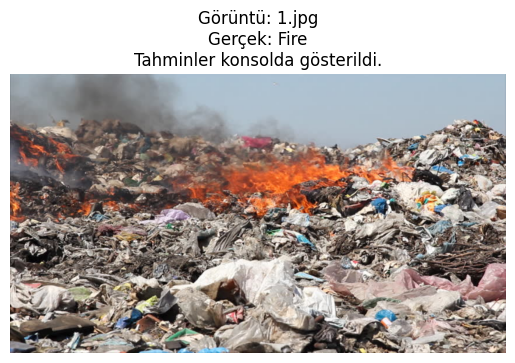


--- Tek görüntü işleniyor: 10.jpg ---
Gerçek Etiket: Fire (1)
  MLP Tarafından Tahmin: Non-Fire (Olasılık: 0.1695)
  LIGHTGBM Tarafından Tahmin: Fire (Olasılık: 0.9991)
  SVM Tarafından Tahmin: Fire


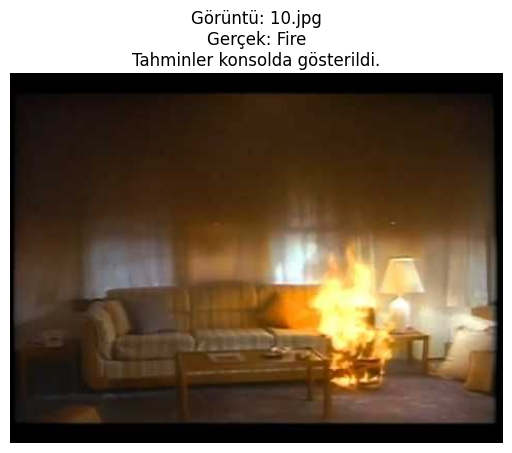


--- Tek görüntü işleniyor: 100.jpg ---
Gerçek Etiket: Fire (1)
  MLP Tarafından Tahmin: Non-Fire (Olasılık: 0.0126)
  LIGHTGBM Tarafından Tahmin: Fire (Olasılık: 0.9985)
  SVM Tarafından Tahmin: Fire


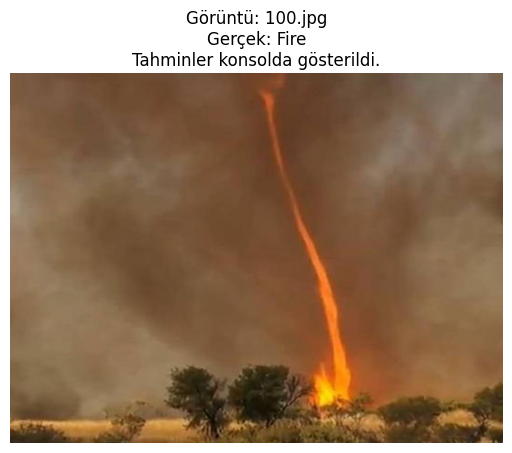


--- Gösterim için 3 örnek YANGINSIZ görüntüsü işleniyor ---

--- Tek görüntü işleniyor: 1.jpg ---
Gerçek Etiket: Non-Fire (0)
  MLP Tarafından Tahmin: Non-Fire (Olasılık: 0.0000)
  LIGHTGBM Tarafından Tahmin: Fire (Olasılık: 0.9968)
  SVM Tarafından Tahmin: Fire


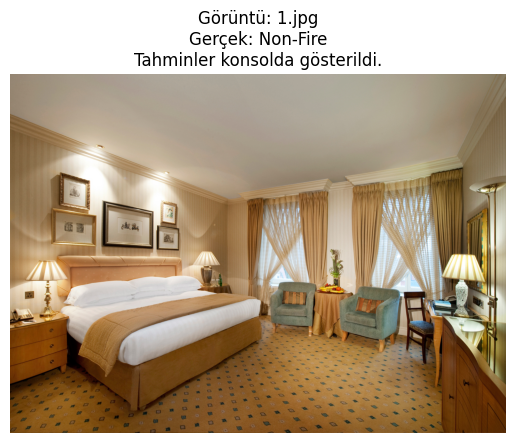


--- Tek görüntü işleniyor: 101.jpg ---
Gerçek Etiket: Non-Fire (0)
  MLP Tarafından Tahmin: Non-Fire (Olasılık: 0.0000)
  LIGHTGBM Tarafından Tahmin: Fire (Olasılık: 0.9986)
  SVM Tarafından Tahmin: Fire


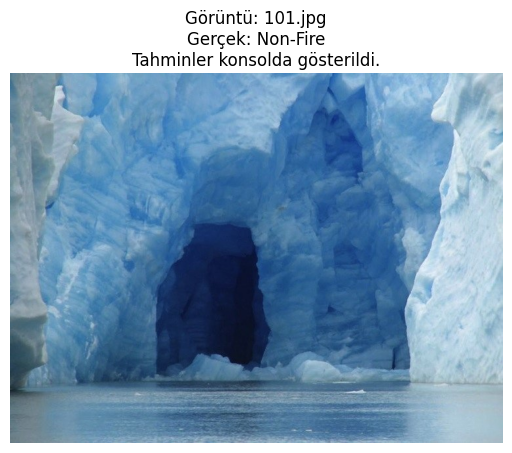


--- Tek görüntü işleniyor: 102.jpg ---
Gerçek Etiket: Non-Fire (0)
  MLP Tarafından Tahmin: Non-Fire (Olasılık: 0.0000)
  LIGHTGBM Tarafından Tahmin: Fire (Olasılık: 0.9972)
  SVM Tarafından Tahmin: Non-Fire


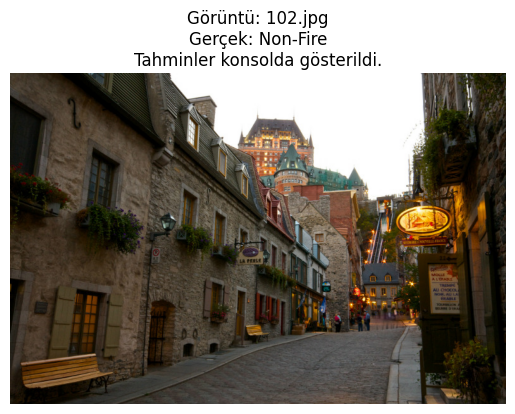


--- Tüm kaggle Özellik Tabanlı Model Değerlendirmeleri Tamamlandı ---


In [ ]:
print(f"\n\n=== Kaggle Özellik Tabanlı Model Kapsamlı Değerlendirmesi ===")
print(f"Proje Kökü: {PROJECT_ROOT}")
print(f"kaggle_ROOT ayarlı: {ROOT_EVAL}")
print(f"kaggle_TRAIN_ROOT ayarlı: {TRAIN_ROOT_EVAL}")
print(f"kaggle_TEST_ROOT ayarlı: {TEST_ROOT_EVAL}")
print(f"MODEL_DIR ayarlı: {MODEL_SAVE_DIR_EVAL}")

models_to_load_and_evaluate_final = [
    {
        'display_name': 'Kaggle Custom MLP (Scaled Corr%50)',
        'model_filename': 'hybrid_kaggle_m1_custom_mlp_best_model_Scaled_Corr50%_CNN.keras',
        'transformer_filename': 'hybrid_kaggle_m1_selector_Scaled_Corr50%_CNN.pkl'
    },
    {
        'display_name': 'Kaggle LightGBM (Scaled Corr%50)',
        'model_filename': 'hybrid_kaggle_m1_lightgbm_best_model_Scaled_Corr50%_CNN.pkl',
        'transformer_filename': 'hybrid_kaggle_m1_selector_Scaled_Corr50%_CNN.pkl'
    },
    {
        'display_name': 'Kaggle SVM (Scaled Corr%50)',
        'model_filename': 'hybrid_kaggle_m1_svm_best_model_Scaled_Corr50%_CNN.pkl',
        'transformer_filename': 'hybrid_kaggle_m1_selector_Scaled_Corr50%_CNN.pkl'
    }
]

global_scaler_filename = 'hybrid_kaggle_m1_global_scaler.pkl'
global_scaler_path = os.path.join(MODEL_SAVE_DIR_EVAL, global_scaler_filename)

global_scaler_obj_eval = None
try:
    global_scaler_obj_eval = joblib.load(global_scaler_path)
    print(f"Genel ölçekleyici yüklendi: {global_scaler_path}")
except Exception as e:
    print(f"Genel ölçekleyici yüklenirken hata: {e}. Özellik tabanlı değerlendirmeye devam edilemiyor.")


if global_scaler_obj_eval:
    feature_params_eval = get_feature_params()
    loaded_artifacts_eval = load_artifacts_for_feature_models_eval(models_to_load_and_evaluate_final, MODEL_SAVE_DIR_EVAL)

    if loaded_artifacts_eval:
        print("\n--- Özellik tabanlı modeller başarıyla yüklendi. Değerlendirmelere devam ediliyor. ---")
        reproduce_original_test_split_features_eval(
            TRAIN_ROOT_EVAL,
            CONFIG_EVAL,
            feature_params_eval,
            global_scaler_obj_eval,
            loaded_artifacts_eval
        )

        evaluate_feature_folder_eval(
            TEST_ROOT_EVAL,
            loaded_artifacts_eval,
            CONFIG_EVAL,
            feature_params_eval,
            global_scaler_obj_eval
        )

        print("\n--- Tek görüntü işleme için örnek görüntüler hazırlanıyor (Özellik Modelleri) ---")
        
        all_test_image_paths = []
        for class_dir in ['fire_images', 'non_fire_images']:
            class_path = os.path.join(TEST_ROOT_EVAL, class_dir)
            if os.path.isdir(class_path):
                for f in os.listdir(class_path):
                    if f.lower().endswith(CONFIG_EVAL['img_extensions']):
                        all_test_image_paths.append(os.path.join(class_path, f))
        all_test_image_paths.sort() 
        fire_images_for_display = []
        non_fire_images_for_display = []

        for img_path in tqdm(all_test_image_paths, desc="Gösterim için test görüntüleri kategorize ediliyor"):
            if is_kaggle_image_fire(img_path): fire_images_for_display.append(img_path)
            else: non_fire_images_for_display.append(img_path)

        num_samples_to_show = min(3, len(fire_images_for_display))
        if num_samples_to_show > 0:
            print(f"\n--- Gösterim için {num_samples_to_show} örnek YANGIN görüntüsü işleniyor ---")
            for i in range(num_samples_to_show):
                process_single_image_feature_model_eval(
                    fire_images_for_display[i],
                    loaded_artifacts_eval,
                    CONFIG_EVAL,
                    feature_params_eval,
                    global_scaler_obj_eval
                )
        else: print("\nTek görüntü işleme için test kümesinde yangın görüntüsü bulunamadı.")

        num_samples_to_show = min(3, len(non_fire_images_for_display))
        if num_samples_to_show > 0:
            print(f"\n--- Gösterim için {num_samples_to_show} örnek YANGINSIZ görüntüsü işleniyor ---")
            for i in range(num_samples_to_show):
                process_single_image_feature_model_eval(
                    non_fire_images_for_display[i],
                    loaded_artifacts_eval,
                    CONFIG_EVAL,
                    feature_params_eval,
                    global_scaler_obj_eval
                )
        else: print("\nTek görüntü işleme için test kümesinde yangınsız görüntü bulunamadı.")
    else: print("Hiçbir özellik tabanlı model başarıyla yüklenmedi. Özellik tabanlı değerlendirme görevleri atlanıyor.")
else: print("Genel ölçekleyicinin eksik olması nedeniyle özellik tabanlı model değerlendirmesine devam edilemiyor.")
print("\n--- Tüm kaggle Özellik Tabanlı Model Değerlendirmeleri Tamamlandı ---")